The pipeline that runs all the functions in the different packages

In [1]:
from ImageGeneration import Generator, Discriminator, Creation
import segmentation
import LavaCreation
import torch
import skimage as ski
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import exposure
from LavaCreation import get_random_points

Removing the Noise from images

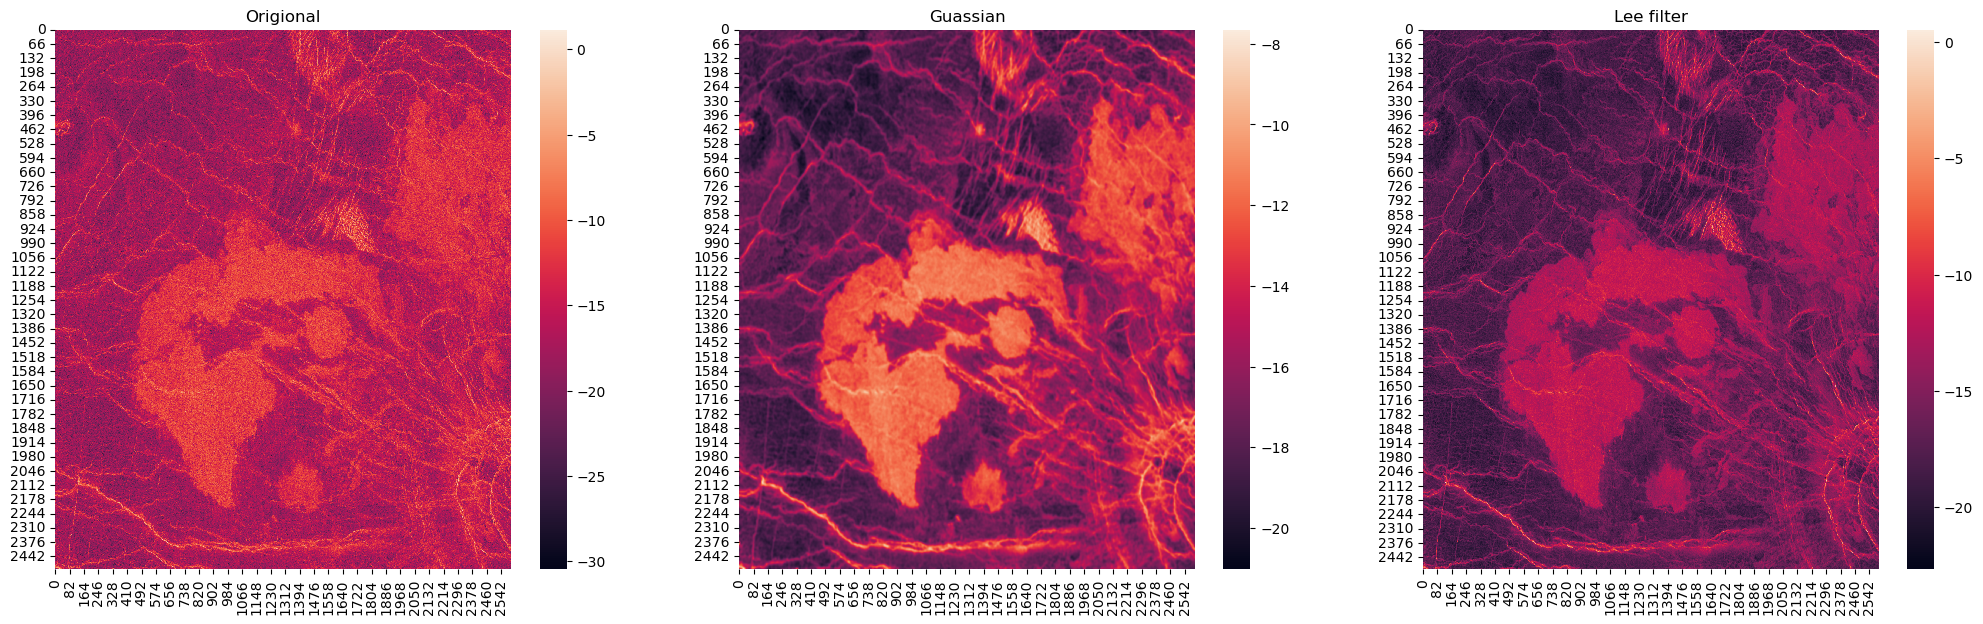

In [6]:
radar =np.load('../LavaGenerationTool/TestLavaImages/radar1.npy')

#Here you can choose to use the Gaussian or the Lee filtered image
gaus_radar, lee_radar =segmentation.anti_pepper(radar, visualise=True)

Creating the shape for the new lava flow

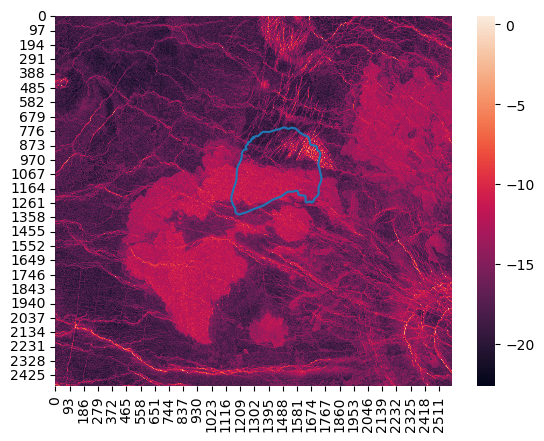

In [7]:
rad = 0.2
edgy = 0.05
sns.heatmap(lee_radar)
a = LavaCreation.get_located_points(lee_radar,n=7,new_lava_position=(1500,1000), size_meters=50000)
x,y, _ = LavaCreation.get_bezier_curve(a,rad=rad, edgy=edgy)
plt.plot(x,y)
plt.show()

Converting the new shape into a mask

<Axes: >

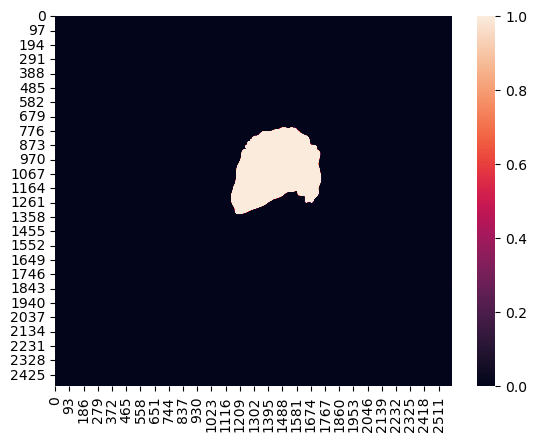

In [8]:
Shape =LavaCreation.PolygonFill(radar_img=radar,polygon_Xcoords=x,polygon_Ycoords=y)
Shape.rasterize_points()
Shape.join_points()
Shape.find_internal_pt()
final_img =Shape.fill_polygon()
sns.heatmap(final_img)

Splitting the images into tiles so to calculate how many tiles would be needed to fill the shape.

In [9]:
img_list =segmentation.list_of_mini_img(segmentation.cropping_img(radar,128),128)
img_poly_list=segmentation.list_of_mini_img(segmentation.cropping_img(final_img,128),128)
assert len(img_list) == len(img_poly_list)

count, indexes =LavaCreation.new_sort(img_poly_list)
#the count is the number of samples needed to fill the lava shape
no_of_samples =count

size of new image 2432 , 2560
(2432, 2560)
size of new image 2432 , 2560
(2432, 2560)


The generating image part with the trained GAN model

In [10]:
model =Creation(ngpu=0) #initiating the Creation class
netG = Generator(model.nz).to(model.device)
netD = Discriminator().to(model.device)

In [11]:
netG.load_state_dict(torch.load('Model_weights/generator_state_dict2.pth'))
netD.load_state_dict(torch.load('Model_weights/discriminator_state_dict2.pth'))
netG.eval()
netD.eval()

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=25, 

Here is the code that adds the Histogram equaliser, however this is an option I chose not to use it in the end as the results were not as good, as without, but it is still optional to use.

In [12]:
#generating the specified number of images
images =model.produce_images(no_of_samples,netG,visualise=False)
backscatter_range =np.min(radar)-np.max(radar)
EH_images =[]
AEH_images=[]
noise_images=[]
for i in range(len(images)):
    AEH, EH =model.historgram_equaliser(image=images[i], visualise=False)
    noisy_AEH =ski.filters.gaussian(model.add_salt_and_pepper_noise
                                    (model.add_gaussian_noise_photo(AEH)), sigma=0.7)
    noisy_EH =ski.filters.gaussian(model.add_salt_and_pepper_noise
                                    (model.add_gaussian_noise_photo(EH)), sigma=0.7)
    noisy_img =ski.filters.gaussian(model.add_salt_and_pepper_noise
                                    (model.add_gaussian_noise_photo(images[i])), sigma=0.7)
    
    EH_images.append(noisy_EH*backscatter_range)
    AEH_images.append(noisy_AEH*backscatter_range)
    noise_images.append(noisy_img*backscatter_range)

#changing the tiles of the origional image to ones that are generated
count=0
for i in indexes: #iterating through the index_values list
    img_list[i] =noise_images[count]
    count+=1


This part is focussed on filling the shape with the lava flow and doing the post processing to make it realistic.

In [13]:
height,width =segmentation.cropping_img(radar,128).shape
new_image =LavaCreation.reassemble_large_array(img_list,height,width)

size of new image 2432 , 2560
(2432, 2560)


### Adjusting the Backscatter

This code segments the radar image so that a laval flow can be chosen to gain the mean and standard deviation values to give to the generated lava flow.

c:\Users\iyc23\AppData\Local\miniconda3\envs\IRP0\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\iyc23\AppData\Local\miniconda3\envs\IRP0\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\iyc23\AppData\Local\miniconda3\envs\IRP0\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\iyc23\AppData\Local\miniconda3\envs\IRP0\Lib\site-packages\seaborn\_old

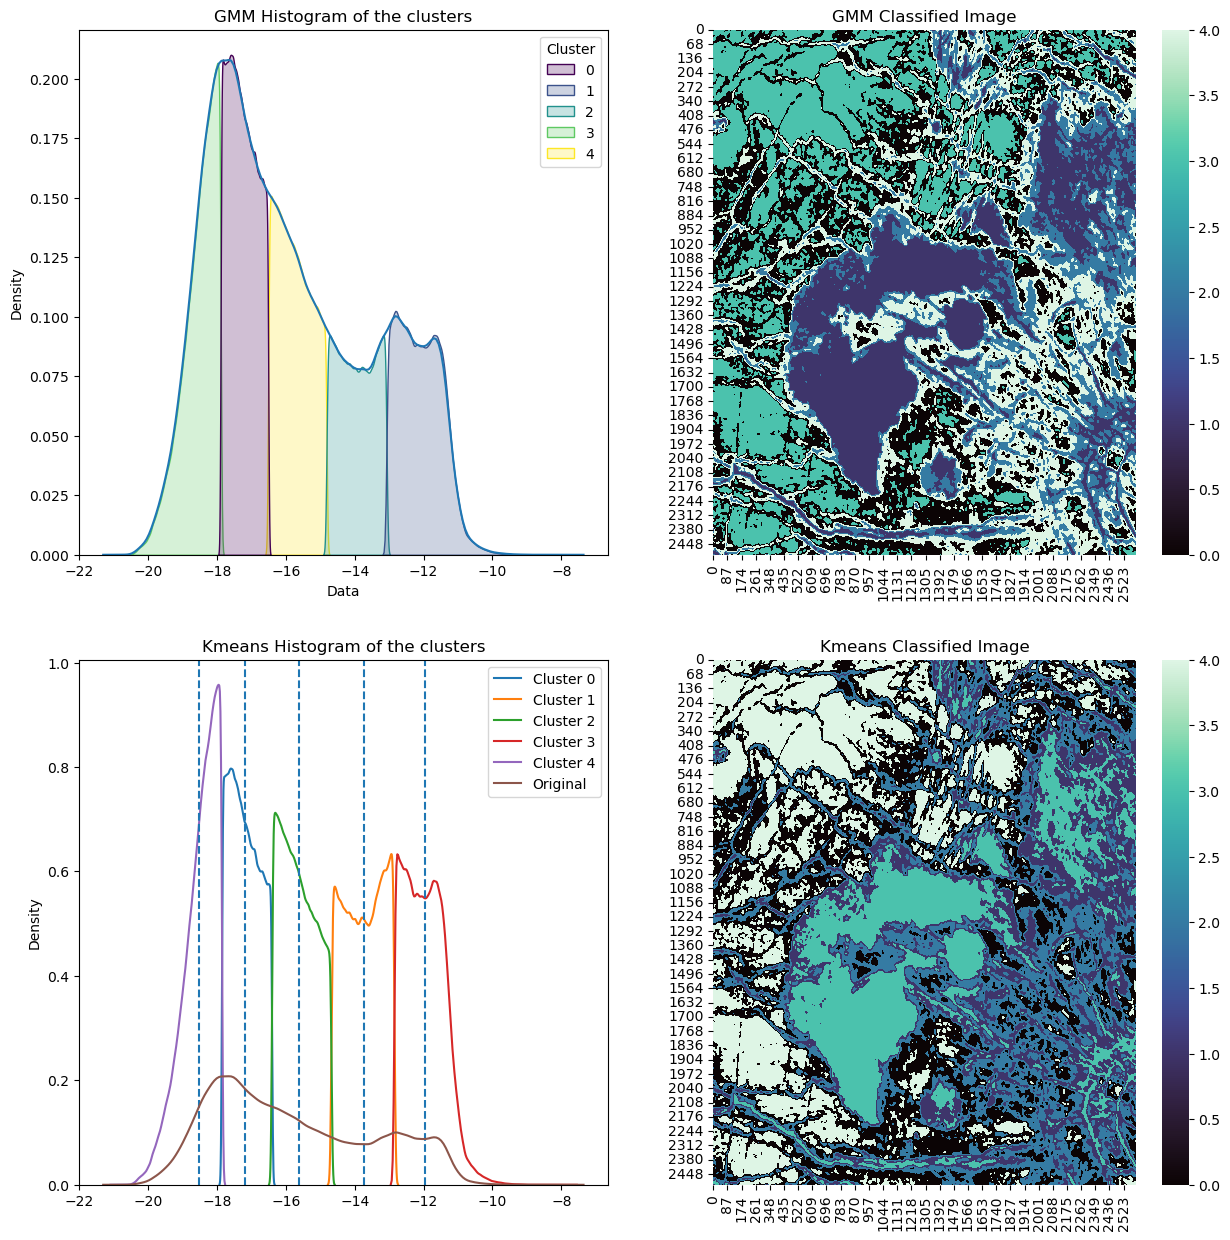

In [14]:
#code to segment the lava flows to obtain a lava flow
gmm_clustered, kmean_clustered, lava_cluster_kmeans, lava_cluster_gm=segmentation.classification(gaus_radar,5,True)

Here coordinates are given to select a lava flow, this is visualised

Number of lava pixels:  1686
Average backscatter value  -16.819966857606268
standard deviation 1.8972395242498932


c:\Users\iyc23\AppData\Local\miniconda3\envs\IRP0\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


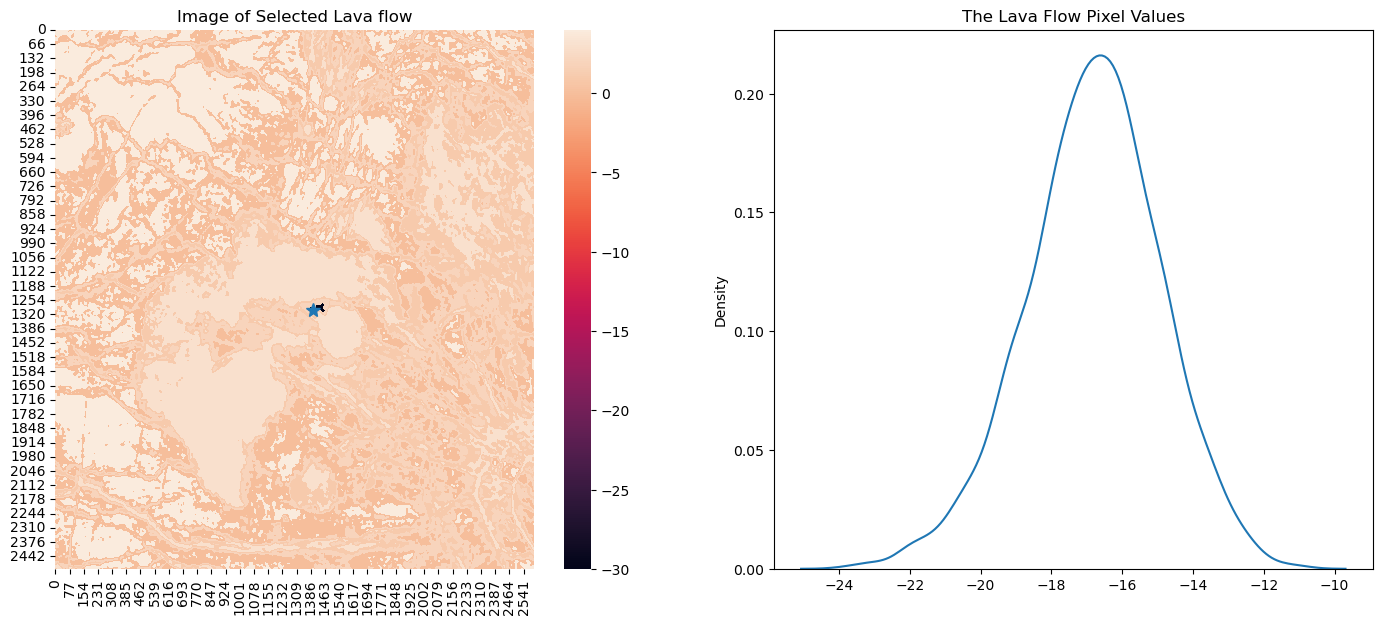

In [15]:
#this code selects the lava flow and calculates its mean and standard deviation
mean_backscatter,backscatter_std,lava_vals,lava_mask=segmentation.find_backscatter(
    origional_array=radar,cluster_array=kmean_clustered,coordinate=(1400,1300),visualise=True)

Adjusting the Generated tiles of lava flow to have the mean and std selected

In [16]:
cropped =new_image[int(np.rint(min(y)))-10:int(np.rint(max(y)))+10,int(np.rint(min(x)))-10:int(np.rint(max(x)))+10]
ahe, eh =model.historgram_equaliser(cropped,visualise=False)
ymin =int(np.rint(min(y)))
xmin=int(np.rint(min(x)))
# finding the range
backscatter_range =np.max(radar)-np.min(radar)
# first need to denormalise
adj_lava =LavaCreation.adjust_values(cropped,(mean_backscatter),backscatter_std)
adj_lava=model.add_speckle_noise(adj_lava, max_val=np.max(radar),min_val=np.min(radar),scale=0.12)

c:\Users\iyc23\AppData\Local\miniconda3\envs\IRP0\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\iyc23\AppData\Local\miniconda3\envs\IRP0\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Pixel Value Distribution of lava flows')

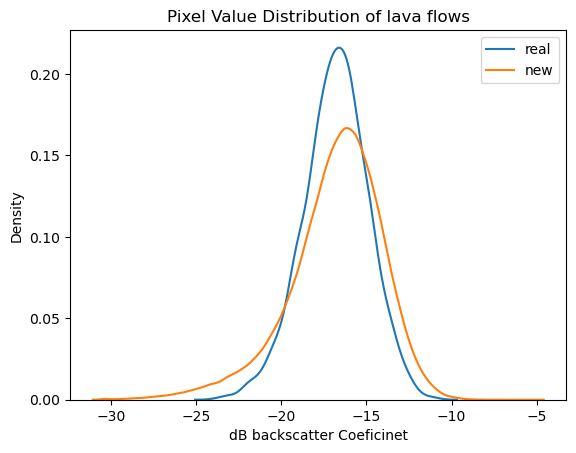

In [17]:
sns.kdeplot(lava_vals, label='real')
sns.kdeplot(adj_lava.flatten(), label='new')
plt.legend()
plt.xlabel('dB backscatter Coeficinet')
plt.title('Pixel Value Distribution of lava flows')

This is constructing the whole image with the lava tiles intergrated into the image

In [18]:
ad =adj_lava[10:-10,10:-10]
for i in range(ad.shape[0]):
    for j in range(ad.shape[1]):
        new_image[i+ymin][j+xmin]=ad[i][j]

In [19]:
cropped_binary_img =segmentation.cropping_img(final_img,128)
cropped_OG_img =segmentation.cropping_img(radar,128)

for i in range(new_image.shape[0]):
    for j in range(new_image.shape[1]):
        if cropped_binary_img[i][j]==0:
            new_image[i][j]=cropped_OG_img[i][j]
        else:
            pass

size of new image 2432 , 2560
(2432, 2560)
size of new image 2432 , 2560
(2432, 2560)


Calculating the ENL of the images

In [20]:
mask = (final_img == 1)
mask =mask[:new_image.shape[0],:new_image.shape[1]]
assert mask.shape ==new_image.shape
segmentation.calculate_enl(new_image,mask)

3.7266472226816965

Visualising Results Code

In [21]:
assert lava_mask.shape == kmean_clustered.shape
for i in range(lava_mask.shape[0]):
    for j in range(lava_mask.shape[1]):
        if lava_mask[i,j]:
            kmean_clustered[i,j]=8

c:\Users\iyc23\AppData\Local\miniconda3\envs\IRP0\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\iyc23\AppData\Local\miniconda3\envs\IRP0\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\iyc23\AppData\Local\Temp\ipykernel_31132\2581895275.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


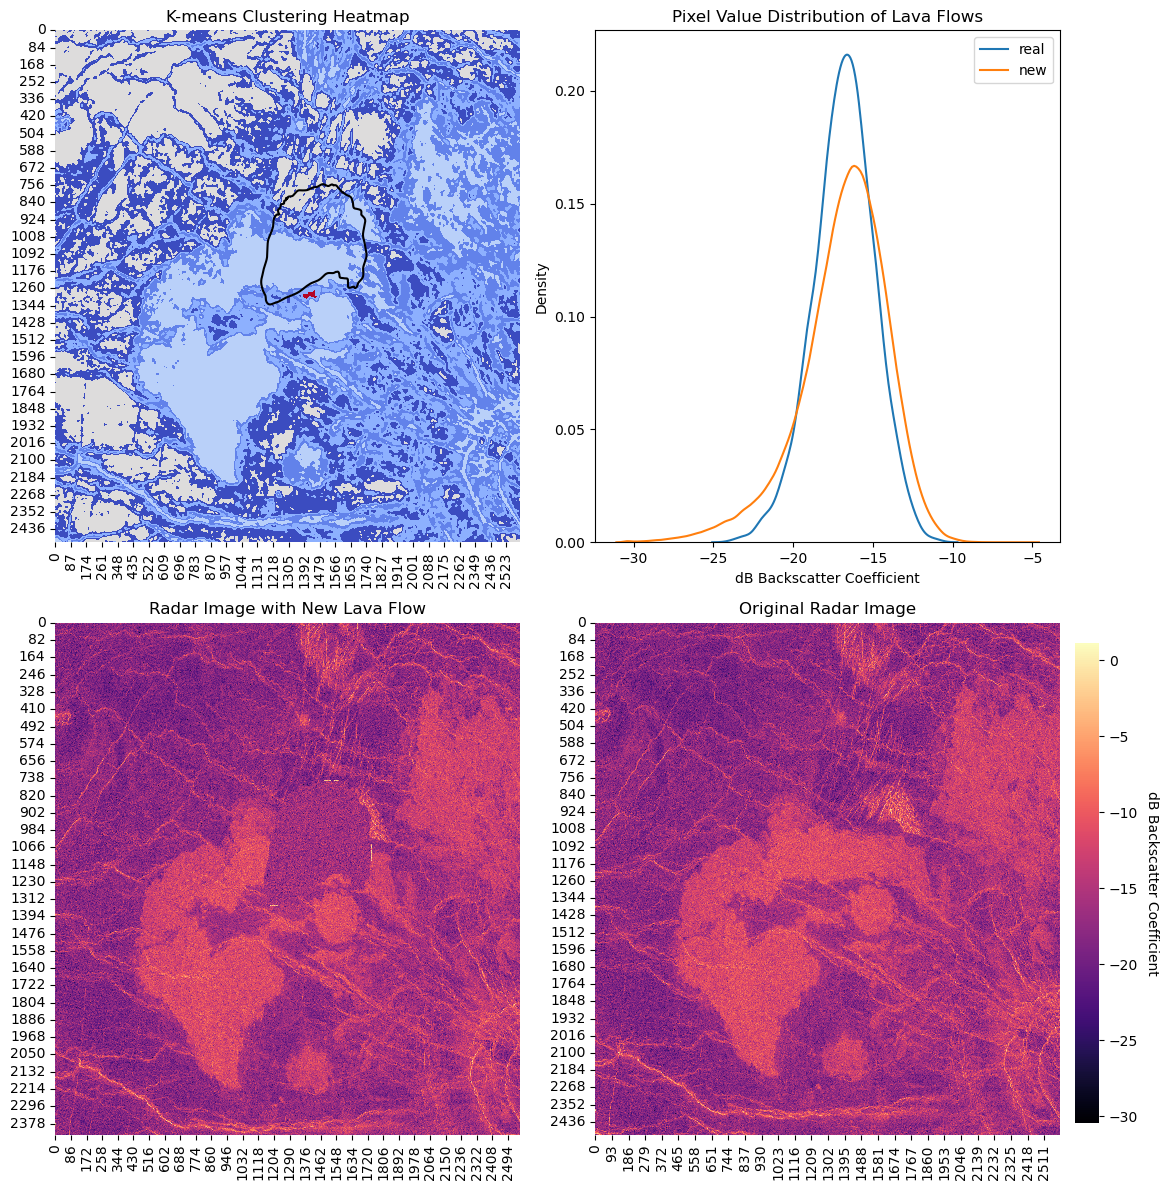

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot 1: Heatmap without colorbar
sns.heatmap(kmean_clustered, cmap='coolwarm', cbar=False, ax=axes[0, 0])
axes[0, 0].plot(x, y, color='black')
axes[0, 0].set_title('K-means Clustering Heatmap')

# Plot 2: KDE plot
sns.kdeplot(lava_vals, label='real', ax=axes[0, 1])
sns.kdeplot(adj_lava.flatten(), label='new', ax=axes[0, 1])
axes[0, 1].legend()
axes[0, 1].set_xlabel('dB Backscatter Coefficient')
axes[0, 1].set_title('Pixel Value Distribution of Lava Flows')

# Plot 3: First heatmap (Radar Image with New Lava Flow)
sns.heatmap(new_image, ax=axes[1, 0], cbar=False, cmap='magma')
axes[1, 0].set_title('Radar Image with New Lava Flow')

# Plot 4: Second heatmap (Original Radar Image)
sns.heatmap(radar, ax=axes[1, 1], cbar=False, cmap='magma')
axes[1, 1].set_title('Original Radar Image')

# Create a single color bar for the bottom two heatmaps
fig.subplots_adjust(right=0.85)  # Adjust the right margin to fit the color bar
cbar_ax = fig.add_axes([0.9, 0.06, 0.02, 0.4])  # Position for the color bar
sns.heatmap(radar, ax=axes[1, 1], cbar=True, cbar_ax=cbar_ax, cmap='magma')

# Add a label to the color bar
#cbar = fig.colorbar(axes[1, 1].collections[0], ax=axes[1, :], orientation='horizontal', fraction=0.05, pad=0.15)
cbar_ax.set_ylabel('dB Backscatter Coefficient', rotation=270, labelpad=15)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])

# Display the plot
plt.show()